In [89]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
import datetime
import pickle
pd.set_option('display.max_columns', None)

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from lightgbm import log_evaluation

In [20]:
path = '/Users/idris/Documents/ds_project/forecast_store_sales/data/'
list_cutoff = ['2017-08-16']

cutoff = '2017-07-31'

col_to_ignore = ["date", "is_future", "forecast_step", "ts_id"]

TARGET_COL = 'sales'

In [1]:
clean = pd.read_csv(path + f'trainclean.csv', sep=';')
clean['date'] = pd.to_datetime(clean['date'])

1

In [86]:
prediction_length = 16
lags_target=list(range(1, 16))
rollings_target=[2, 4, 8, 16]


def calculate_lags(df, col, lags, shift=0):
    for l in lags:
        df[f"lag_{col}_{l}"] = df.groupby(["ts_id"])[col].shift(shift + l).astype(np.float16)

def calculate_rollings(df, col, rollings, shift=0):
    for r in rollings:
        df[f"rol_mean_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).mean()
        df[f"rol_std_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).std()
        df[f"rol_min_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).min()
        df[f"rol_max_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).max()

        
def RMSLE(y_true:np.ndarray, y_pred:np.ndarray) -> np.float64:

    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [114]:
df_cutoff_b = pd.read_csv(path + f'fe/cutoff/{cutoff}/final_frame.csv', sep=';').drop('transactions', axis=1)

/var/folders/4n/2ycm0xd14jgb1blvw6f3mzvr0000gn/T/ipykernel_15467/2728142366.py:1: DtypeWarning: Columns (155) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cutoff_b = pd.read_csv(path + f'fe/cutoff/{cutoff}/final_frame.csv', sep=';').drop('transactions', axis=1)


In [115]:
df_cutoff_b['date'] = pd.to_datetime(df_cutoff_b['date'])

In [116]:
df_cutoff = df_cutoff_b.copy()

In [117]:
df_train = df_cutoff.loc[df_cutoff["is_future"] == False].drop(columns=col_to_ignore)

train_ds = lgb.Dataset(
    data=df_train.drop(columns=TARGET_COL), 
    label=df_train[TARGET_COL]
)

In [118]:
#default
params = {
    "boosting_type": "gbdt", 
    "num_leaves": 31, 
    "max_depth": -1, 
    "learning_rate": 0.1, 
    "n_estimators": 1000, #100
    "subsample_for_bin": 200000, 
    "objective": "regression", #None
    "class_weight": None, 
    "min_split_gain": 0.0, 
    "min_child_weight": 0.001, 
    "min_child_samples": 20, 
    "subsample": 1.0, 
    "subsample_freq": 0, 
    "colsample_bytree": 1.0, 
    "reg_alpha": 0.0, 
    "reg_lambda": 0.0, 
    "random_state": 666, 
    "n_jobs": -1, 
    "metric": "rmse"
}


# Tuned
params = {
    "boosting_type": "gbdt", 
    "num_leaves": 2**8-1,
    "max_depth": -1, 
    "learning_rate": 0.015,
    "n_estimators": 1000, #100
    "subsample_for_bin": 200000, 
    "objective": "tweedie", #None
    "tweedie_variance_power": 1.1,
    "class_weight": None, 
    "min_split_gain": 0.0, 
    "min_child_weight": 0.001, 
    "min_child_samples": 20, 
    "subsample": 0.35,
    "subsample_freq": 10,
    "colsample_bytree": 1.0, 
    "reg_alpha": 0.0, 
    "reg_lambda": 0.0, 
    "random_state": 666, 
    "n_jobs": -1, 
    "metric": "rmse",
    'min_data_in_leaf': 2**8-1,
    'feature_fraction': 0.35,
}


params ={
     "boosting_type": "gbdt",
     "max_depth": -1,
     "subsample_for_bin": 200000,
     "class_weight": None,
     "random_state": 1990,
     "metric": "rmse",
     "min_split_gain": 0.0,
     "min_child_weight": 0.001, 
     'n_estimators': 500,
     'num_leaves': 10,
     'learning_rate': 0.17381447305763387,
     'objective': 'tweedie',
     'min_child_samples': 80,
     'subsample': 0.9,
     'colsample_bytree': 0.6000000000000001,
     'reg_alpha': 1.0,
     'reg_lambda': 0.6000000000000001,
     'tweedie_variance_power': 1.1,
     'subsample_freq': 1,
     
}

'''
params = { 
     "boosting_type": "gbdt",
     "max_depth": -1,
     "subsample_for_bin": 200000,
     "class_weight": None,
     "random_state": 1990,
     "metric": "rmse",
     "min_split_gain": 0.0,
     "min_child_weight": 0.001, 
     'n_estimators': 500,
     'num_leaves': 10,
     'learning_rate': 0.030115426337437638,
     'objective': 'regression',
     'min_child_samples': 60,
     'subsample': 0.7000000000000001,
     'colsample_bytree': 0.6000000000000001,
     'reg_alpha': 0.1,
     'reg_lambda': 0.0,
     'subsample_freq': 1
}
'''
params = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'tweedie_variance_power': 1.1,
        'metric': 'rmse',
        'max_bin': 100,
        'subsample': 0.5,
        'subsample_freq': 1,
        'learning_rate': 0.015,
        'num_leaves': 2**11-1,
        'min_data_in_leaf': 2**12-1,
        'feature_fraction': 0.5,
        'n_estimators': 1300,
        'boost_from_average': False
                } 

#0.14
params = {
    "objective": "tweedie",
    "tweedie_variance_power": 1.3,
    "n_estimators": 2000,
    "learning_rate": 0.08064028714756555,
    "num_leaves": 2140,
    "max_depth": 12,
    "min_data_in_leaf": 200,
    "lambda_l1": 10,
    "lambda_l2": 55,
    "min_gain_to_split": 7.674179670757204,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "feature_fraction": 0.9,
    "random_state": 1990,
    "metric": "rmse",
    "verbose": -1
    }

#0.149
params = {
    "objective": "tweedie",
    'tweedie_variance_power': 1.4,
    'n_estimators': 2000,
    'learning_rate': 0.12406019277516293,
    'num_leaves': 760,
    'max_depth': 10,
    'min_data_in_leaf': 1000,
    'lambda_l1': 65,
    'lambda_l2': 35,
    'min_gain_to_split': 8.80719878690136,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'feature_fraction': 0.4,
    "random_state": 1990,
    "metric": "rmse",
    "verbose": -1
}


In [119]:
# Fit
gbm = lgb.train(
    params=params,
    train_set=train_ds,
    valid_sets=train_ds,
    callbacks=[log_evaluation(period=10)]
)

/Users/idris/miniconda3/envs/forecast/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	training's rmse: 744.066
[20]	training's rmse: 392.244
[30]	training's rmse: 299.468
[40]	training's rmse: 281.024
[50]	training's rmse: 270.497
[60]	training's rmse: 262.566
[70]	training's rmse: 255.728
[80]	training's rmse: 251.759
[90]	training's rmse: 249.094
[100]	training's rmse: 246.682
[110]	training's rmse: 245.309
[120]	training's rmse: 243.854
[130]	training's rmse: 242.758
[140]	training's rmse: 241.962
[150]	training's rmse: 240.688
[160]	training's rmse: 239.264
[170]	training's rmse: 238.199
[180]	training's rmse: 237.552
[190]	training's rmse: 236.721
[200]	training's rmse: 235.865
[210]	training's rmse: 235.014
[220]	training's rmse: 234.086
[230]	training's rmse: 233.347
[240]	training's rmse: 232.538
[250]	training's rmse: 232.057
[260]	training's rmse: 231.431
[270]	training's rmse: 230.853
[280]	training's rmse: 230.352
[290]	training's rmse: 229.778
[300]	training's rmse: 229.016
[310]	training's rmse: 228.593
[320]	training's rmse: 228.057
[330]	training's 

In [120]:
df_cutoff.loc[df_cutoff["is_future"] == True, "sales"] = np.nan

for fs in range(1, prediction_length + 1):
    print(fs)
    
    # predict one step
    df_predict = df_cutoff.loc[df_cutoff["forecast_step"] == fs].drop(columns=col_to_ignore + [TARGET_COL])
    predictions = np.clip(gbm.predict(df_predict), a_min=0, a_max=None)
    
    # update sales_quantity usings predictions
    df_cutoff.loc[df_cutoff["forecast_step"] == fs, "sales"] = predictions
    
    # update target lags & rollings
    calculate_lags(df_cutoff, TARGET_COL, lags_target)
    calculate_rollings(df_cutoff, TARGET_COL, rollings_target)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [121]:
df_forecast = df_cutoff.loc[df_cutoff["is_future"] == True, ["ts_id", "date", "sales"]]
df_forecast["forecast"] = df_forecast["sales"].round(0).astype(int)
df_forecast.drop(columns="sales", inplace=True)

df_error = pd.merge(df_forecast, clean[['ts_id', 'date', 'sales']], how="left", on=['ts_id', 'date'])
wape = np.round(np.sum(np.abs(df_error["sales"] - df_error["forecast"])) / np.sum(df_error["sales"]), 3)

from sklearn.metrics import mean_squared_error, mean_squared_log_error
rmse = mean_squared_error(df_error["sales"], df_error["forecast"], squared=False)
rmsle = RMSLE(df_error["sales"], df_error["forecast"])

wape, rmse, rmsle

(0.153, 248.0910679536091, 0.45396915317481723)

In [122]:
feature_imp = pd.DataFrame({'Value':gbm.feature_importance(importance_type='gain'),'Feature':gbm.feature_name()})
feature_imp.sort_values('Value', ascending=False, inplace=True)
feature_imp.head()

,Value,Feature
114,1.954774e+08,rol_mean_sales_8
106,1.007002e+08,rol_mean_sales_2
117,8.091993e+07,rol_max_sales_8
118,6.750950e+07,rol_mean_sales_16
122,4.441830e+07,rol_mean_sales_26


In [131]:
feature_keep = feature_imp['Feature'][:75].unique()
feature_keep

array(['rol_mean_sales_8', 'rol_mean_sales_2', 'rol_max_sales_8',
       'rol_mean_sales_16', 'rol_mean_sales_26', 'rol_max_sales_2',
       'lag_sales_7', 'rol_mean_sales_4', 'lag_sales_14', 'lag_sales_63',
       'lag_sales_1', 'isclosed', 'lag_sales_28', 'lag_sales_42',
       'lag_sales_56', 'lag_sales_91', 'day', 'lag_sales_21',
       'mean_sales_by_famid', 'rol_max_sales_16', 'onprom', 'dayofweek',
       'std_sales_by_stateid_famid', 'week', 'rol_min_sales_2',
       'rol_mean_sales_104', 'time_idx', 'lag_sales_35', 'month',
       'mean_sales_by_stateid_famid', 'std_sales_by_famid',
       'lag_sales_49', 'prixoil', 'sinweek', 'weekofmonth', 'lag_sales_6',
       'lag_sales_98', 'rol_std_sales_4', 'cosweek', 'lag_sales_8',
       'rol_std_sales_8', 'rol_std_sales_104', 'famid', 'lag_sales_84',
       'rol_min_sales_8', 'rol_mean_sales_52', 'rol_std_sales_16',
       'lag_sales_23', 'rol_std_sales_52', 'lag_sales_77', 'lag_sales_58',
       'lag_sales_15', 'lag_sales_22', 'lag_

In [128]:
df_cutoff = df_cutoff_b.copy()

train_ds = lgb.Dataset(
    data=df_train.drop(columns=TARGET_COL)[feature_keep], 
    label=df_train[TARGET_COL]
)

# Fit
gbm = lgb.train(
    params=params,
    train_set=train_ds,
    valid_sets=train_ds,
    callbacks=[log_evaluation(period=10)]
)

/Users/idris/miniconda3/envs/forecast/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	training's rmse: 744.798
[20]	training's rmse: 393.688
[30]	training's rmse: 303.721
[40]	training's rmse: 283.063
[50]	training's rmse: 272.281
[60]	training's rmse: 266.593
[70]	training's rmse: 261.738
[80]	training's rmse: 257.969
[90]	training's rmse: 256.023
[100]	training's rmse: 254.406
[110]	training's rmse: 252.293
[120]	training's rmse: 250.165
[130]	training's rmse: 249.03
[140]	training's rmse: 247.744
[150]	training's rmse: 246.975
[160]	training's rmse: 245.327
[170]	training's rmse: 244.325
[180]	training's rmse: 243.659
[190]	training's rmse: 242.783
[200]	training's rmse: 242.006
[210]	training's rmse: 241.124
[220]	training's rmse: 240.645
[230]	training's rmse: 240.066
[240]	training's rmse: 239.549
[250]	training's rmse: 239.16
[260]	training's rmse: 238.617
[270]	training's rmse: 237.993
[280]	training's rmse: 237.72
[290]	training's rmse: 237.207
[300]	training's rmse: 236.965
[310]	training's rmse: 236.613
[320]	training's rmse: 236.319
[330]	training's rms

In [129]:
df_cutoff.loc[df_cutoff["is_future"] == True, "sales"] = np.nan

for fs in range(1, prediction_length + 1):
    print(fs)
    
    # predict one step
    df_predict = df_cutoff.loc[df_cutoff["forecast_step"] == fs].drop(columns=col_to_ignore + [TARGET_COL])[feature_keep]
    predictions = np.clip(gbm.predict(df_predict), a_min=0, a_max=None)
    
    # update sales_quantity usings predictions
    df_cutoff.loc[df_cutoff["forecast_step"] == fs, "sales"] = predictions
    
    # update target lags & rollings
    calculate_lags(df_cutoff, TARGET_COL, lags_target)
    calculate_rollings(df_cutoff, TARGET_COL, rollings_target)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [130]:
df_forecast = df_cutoff.loc[df_cutoff["is_future"] == True, ["ts_id", "date", "sales"]]
df_forecast["forecast"] = df_forecast["sales"].round(0).astype(int)
df_forecast.drop(columns="sales", inplace=True)

df_error = pd.merge(df_forecast, clean[['ts_id', 'date', 'sales']], how="left", on=['ts_id', 'date'])
wape = np.round(np.sum(np.abs(df_error["sales"] - df_error["forecast"])) / np.sum(df_error["sales"]), 3)

from sklearn.metrics import mean_squared_error, mean_squared_log_error
rmse = mean_squared_error(df_error["sales"], df_error["forecast"], squared=False)
rmsle = RMSLE(df_error["sales"], df_error["forecast"])

wape, rmse, rmsle

(0.144, 226.56481174826516, 0.45086457572885064)

In [ ]:
all (0.153, 248.0910679536091, 0.45396915317481723)
75 (0.148, 238.75168743891655, 0.44037548609823973)
50 (0.144, 226.56481174826516, 0.45086457572885064)

In [ ]:
{'tweedie_variance_power': 1.4, 'n_estimators': 2000, 'learning_rate': 0.18258547897154484, 'num_leaves': 2780, 'max_depth': 9, 'min_data_in_leaf': 1700, 'lambda_l1': 70, 'lambda_l2': 25, 'min_gain_to_split': 0.4106336891528961, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}

In [9]:
gbm.params

{'objective': 'tweedie',
 'tweedie_variance_power': 1.3,
 'learning_rate': 0.07409359220891601,
 'num_leaves': 2260,
 'max_depth': 9,
 'min_data_in_leaf': 3400,
 'lambda_l1': 85,
 'lambda_l2': 65,
 'min_gain_to_split': 7.823388094632437,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'feature_fraction': 0.7,
 'random_state': 1990,
 'metric': 'rmse',
 'verbose': -1,
 'num_iterations': 2000,
 'early_stopping_round': None}

In [76]:
zero_features = list(feature_imp[feature_imp['Value'] <= 1000]['Feature'])
print('\nThere are %d features with 0.0 importance' % len(zero_features))


There are 44 features with 0.0 importance


In [10]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),df_train.columns)), columns=['Value','Feature'])
feature_imp.sort_values('Value', ascending=False)

,Value,Feature
174,3118,time_idx
173,2272,id
172,1974,hol_after_1
171,1753,lag_sales_6
170,1701,weekofmonth
...,...,...
4,61,hol_before_1
3,50,mean_sales_by_stateid_cityid
2,41,month
1,23,year


In [ ]:
x_train.columns

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

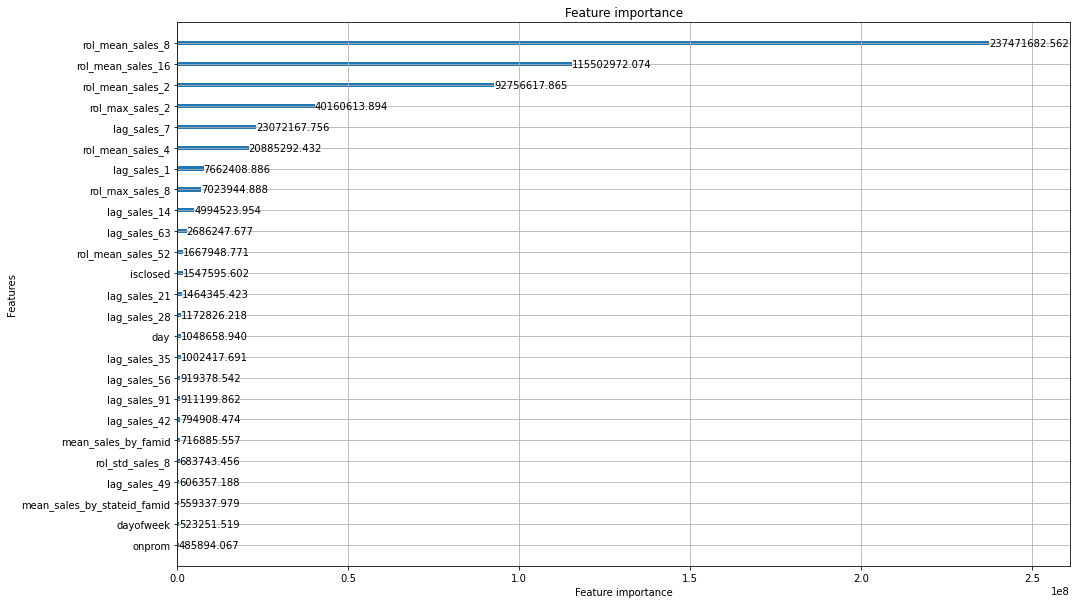

In [56]:
from lightgbm import plot_importance
plot_importance(gbm, importance_type="gain", figsize=(16,10), max_num_features=25)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

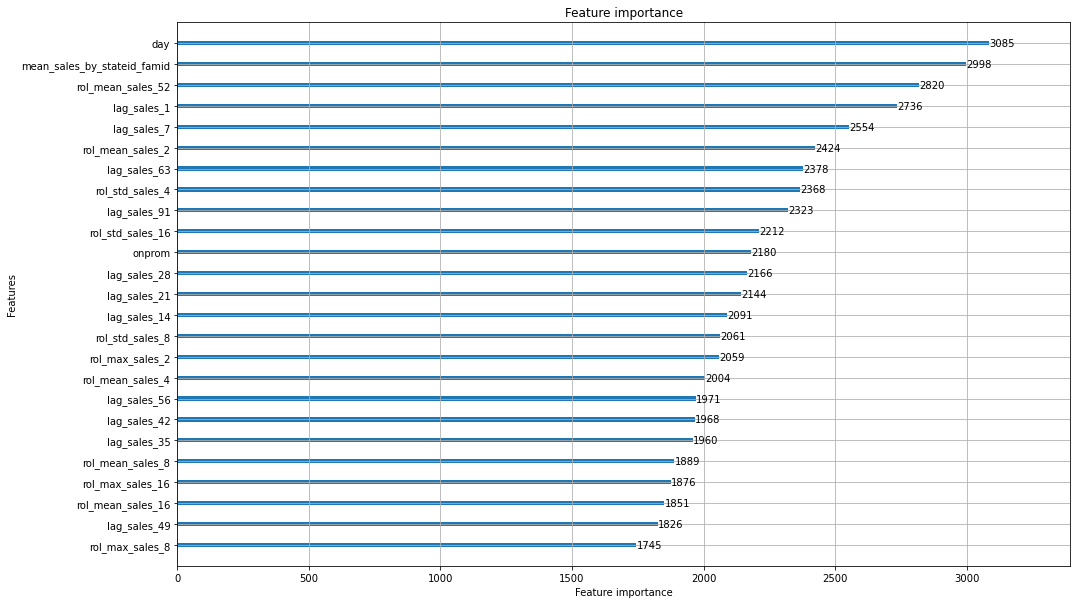

In [57]:
from lightgbm import plot_importance
plot_importance(gbm, importance_type="split", figsize=(16,10), max_num_features=25)

In [58]:
prediction_length = 16
lags_target=list(range(1, 16))
rollings_target=[2, 4, 8, 16]


def calculate_lags(df, col, lags, shift=0):
    for l in lags:
        df[f"lag_{col}_{l}"] = df.groupby(["ts_id"])[col].shift(shift + l).astype(np.float16)

def calculate_rollings(df, col, rollings, shift=0):
    for r in rollings:
        df[f"rol_mean_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).mean()
        df[f"rol_std_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).std()
        df[f"rol_min_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).min()
        df[f"rol_max_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).max()


In [59]:
df_cutoff.loc[df_cutoff["is_future"] == True, "sales"] = np.nan

for fs in range(1, prediction_length + 1):
    print(fs)
    
    # predict one step
    df_predict = df_cutoff.loc[df_cutoff["forecast_step"] == fs].drop(columns=col_to_ignore + [TARGET_COL])
    predictions = np.clip(gbm.predict(df_predict), a_min=0, a_max=None)
    
    # update sales_quantity usings predictions
    df_cutoff.loc[df_cutoff["forecast_step"] == fs, "sales"] = predictions
    
    # update target lags & rollings
    calculate_lags(df_cutoff, TARGET_COL, lags_target)
    calculate_rollings(df_cutoff, TARGET_COL, rollings_target)

1


[LightGBM] [Fatal] The number of features in data (175) is not the same as it was in training data (30).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (175) is not the same as it was in training data (30).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [29]:
df_forecast = df_cutoff.loc[df_cutoff["is_future"] == True, ["ts_id", "date", "sales"]]
df_forecast["forecast"] = df_forecast["sales"].round(0).astype(int)
df_forecast.drop(columns="sales", inplace=True)

In [30]:
clean = pd.read_csv(path + f'trainclean.csv', sep=';')
clean['date'] = pd.to_datetime(clean['date'])

In [31]:
df_error = pd.merge(df_forecast, clean[['ts_id', 'date', 'sales']], how="left", on=['ts_id', 'date'])
wape = np.round(np.sum(np.abs(df_error["sales"] - df_error["forecast"])) / np.sum(df_error["sales"]), 3)
wape

0.163

In [ ]:
{'num_leaves': 10,
 'learning_rate': 0.17381447305763387,
 'objective': 'tweedie',
 'min_child_samples': 80,
 'subsample': 0.9,
 'colsample_bytree': 0.6000000000000001,
 'reg_alpha': 1.0,
 'reg_lambda': 0.6000000000000001,
 'tweedie_variance_power': 1.1,
 'subsample_freq': 1}

In [15]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [16]:
x_train = df_cutoff.drop(columns=TARGET_COL)
x_train["time_idx"] = ((x_train["date"] - x_train["date"].min()).dt.days).astype(int)

In [82]:
for train_idx, test_idx in GroupTimeSeriesSplit().split(x_train, groups=x_train['time_idx']):
    print(x_train.loc[train_idx, 'time_idx'].unique())
    print(x_train.loc[test_idx, 'time_idx'].unique()[:16])
    

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [83]:
1

1